In [6]:
# ======================================================
# 1️⃣ Import Libraries
# ======================================================
import pandas as pd
import numpy as np
import joblib
import onnxruntime as ort

# ======================================================
# 2️⃣ Configuration
# ======================================================
SEQUENCE_LENGTH = 30
crit_thresh = 18.622055
warn_thresh = 4.605819
feature_cols = ['soil_mean', 'rain_mean', 'temp_mean', 'humi_mean', 'geo_mean']

# ======================================================
# 3️⃣ Load Scaler & ONNX Model
# ======================================================
scaler = joblib.load("scaler_fit.save")
session = ort.InferenceSession("lstm_autoencoder_model_opset11.onnx")

# ======================================================
# 4️⃣ Load and Combine Data
# ======================================================
df1 = pd.read_csv("../../data/dev101_resample1T.csv")
df2 = pd.read_csv("../../data/dev102_resample1T.csv")
df_all = pd.concat([df1, df2], ignore_index=True)
df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
df_all.sort_values('timestamp', inplace=True)

# ======================================================
# 5️⃣ Scale Features
# ======================================================
X_scaled = scaler.transform(df_all[feature_cols])
for i, col in enumerate(feature_cols):
    df_all[f"scaled_{col}"] = X_scaled[:, i]

# ======================================================
# 6️⃣ Create Sequences
# ======================================================
X_seq = []
for i in range(len(df_all) - SEQUENCE_LENGTH + 1):
    seq = df_all[[f"scaled_{c}" for c in feature_cols]].iloc[i:i+SEQUENCE_LENGTH].values
    X_seq.append(seq)
X_seq = np.array(X_seq, dtype=np.float32)
print("✅ Sequences shape:", X_seq.shape)

# ======================================================
# 7️⃣ ONNX Inference Function
# ======================================================
def run_onnx_inference(session, X_seq):
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    scores = []
    for x in X_seq:
        x_input = np.expand_dims(x, axis=0).astype(np.float32)  # (1, SEQUENCE_LENGTH, features)
        y_pred = session.run([output_name], {input_name: x_input})[0]
        mse = np.mean((x_input - y_pred) ** 2)
        scores.append(mse)
    return np.array(scores)

# ======================================================
# 8️⃣ Predict Reconstruction Error
# ======================================================
scores = run_onnx_inference(session, X_seq)

# ======================================================
# 9️⃣ Classify Risk
# ======================================================
def classify_risk(score):
    if score > crit_thresh:
        return "Critical"
    elif score > warn_thresh:
        return "Warning"
    else:
        return "Normal"

df_results = df_all.iloc[SEQUENCE_LENGTH-1:].copy()
df_results['recon_error'] = scores
df_results['predicted_risk'] = df_results['recon_error'].apply(classify_risk)

# ======================================================
# 10️⃣ Optional: Summary
# ======================================================
print(df_results[['timestamp', 'recon_error', 'predicted_risk']].head(20))
print(df_results['predicted_risk'].value_counts())


✅ Sequences shape: (85279, 30, 5)
                timestamp  recon_error predicted_risk
14    2025-05-02 11:56:00     0.019469         Normal
42043 2025-05-02 11:57:00     0.022191         Normal
15    2025-05-02 11:57:00     0.021893         Normal
42044 2025-05-02 11:58:00     0.021512         Normal
16    2025-05-02 11:58:00     0.021728         Normal
42045 2025-05-02 11:59:00     0.024839         Normal
17    2025-05-02 11:59:00     0.022805         Normal
42046 2025-05-02 12:00:00     0.027732         Normal
18    2025-05-02 12:00:00     0.029177         Normal
19    2025-05-02 12:01:00     0.027197         Normal
42047 2025-05-02 12:01:00     0.030321         Normal
20    2025-05-02 12:02:00     0.027079         Normal
42048 2025-05-02 12:02:00     0.023937         Normal
42049 2025-05-02 12:03:00     0.022182         Normal
21    2025-05-02 12:03:00     0.022752         Normal
42050 2025-05-02 12:04:00     0.022543         Normal
22    2025-05-02 12:04:00     0.023579         N

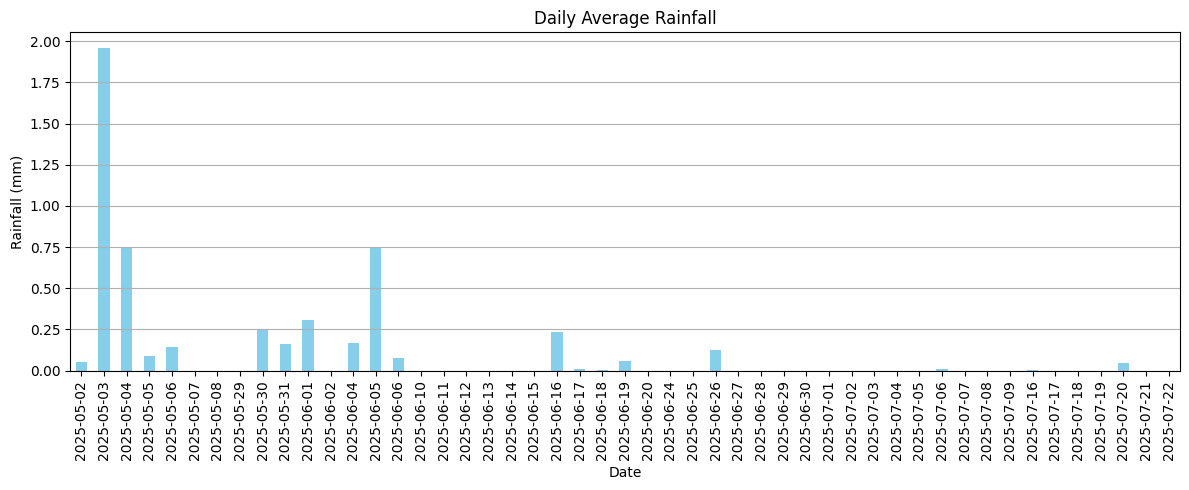

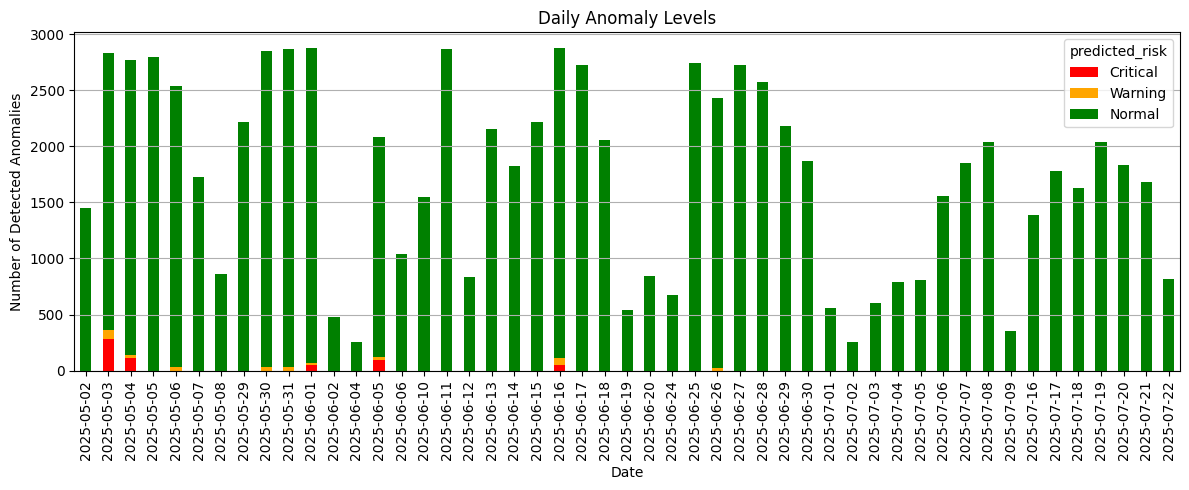

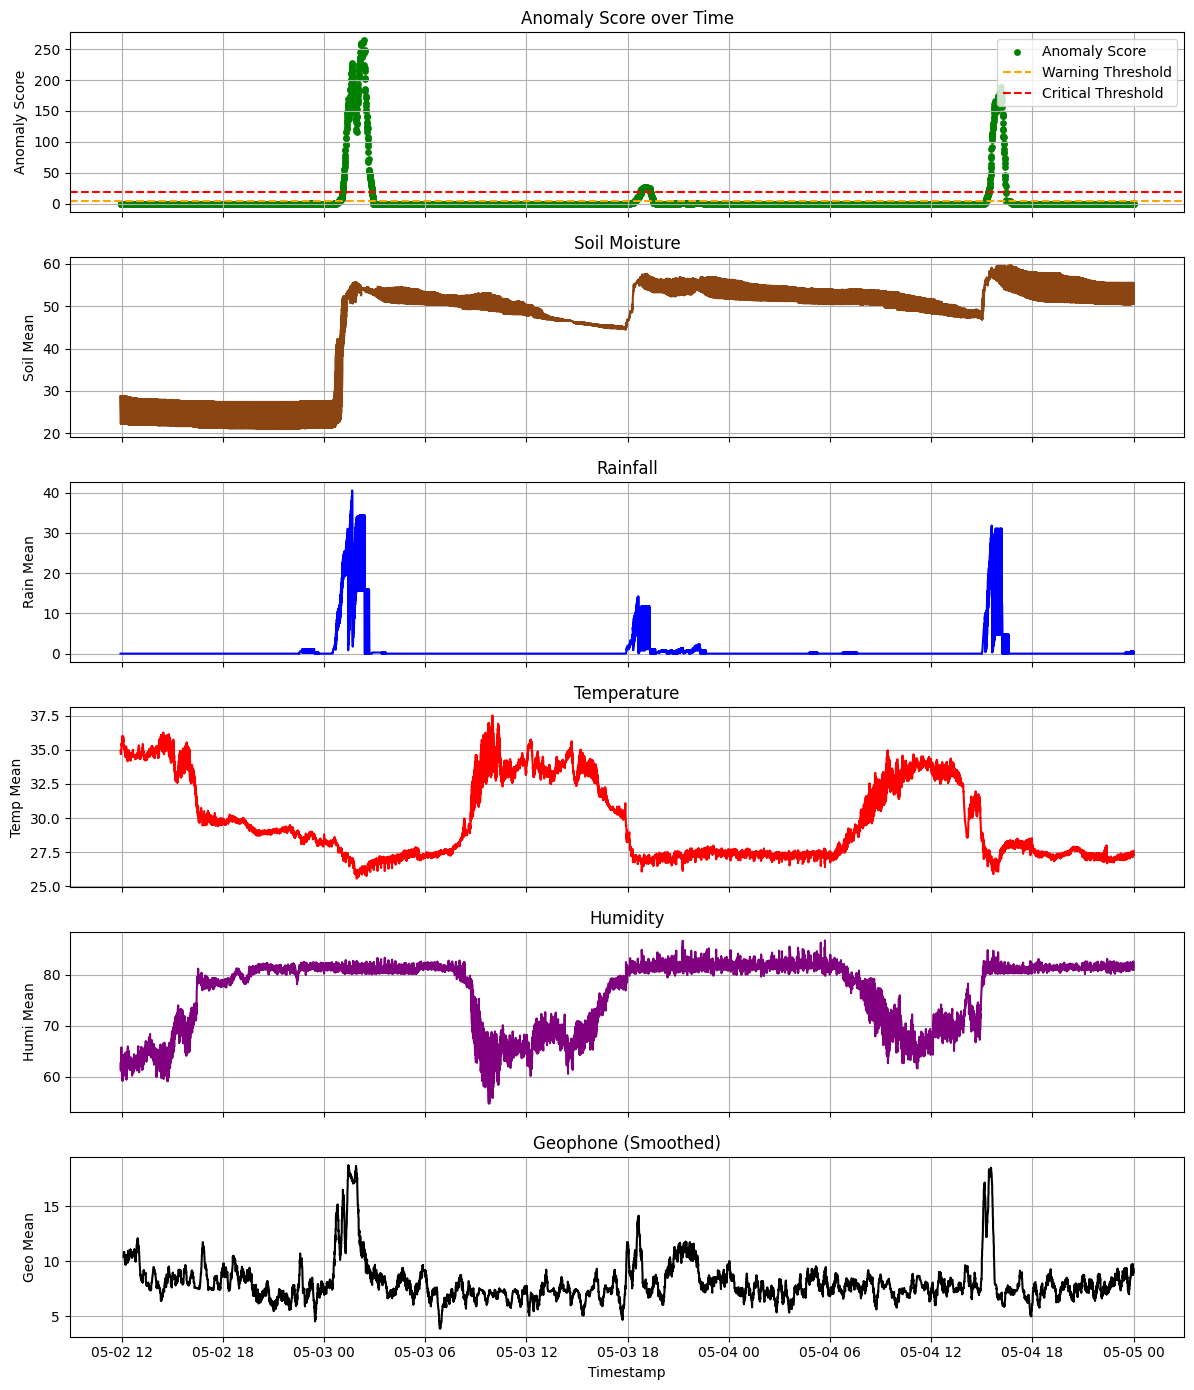

In [5]:

import matplotlib.pyplot as plt
palette = {
    'Critical': 'red',
    'Warning': 'orange',
    'Normal': 'green'
}

# ======================================================
# 12️⃣ Daily Aggregation and Plots
# ======================================================
df_results_daily = df_results.copy()
df_results_daily['date'] = pd.to_datetime(df_results_daily['timestamp']).dt.date

# --- Daily Average Rainfall ---
rain_per_day = df_results_daily.groupby('date')['rain_mean'].mean()
plt.figure(figsize=(12,5))
rain_per_day.plot(kind='bar', color='skyblue')
plt.title("Daily Average Rainfall")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- Daily Anomaly Levels (stacked) ---
label_order = ['Critical', 'Warning', 'Normal']
alerts_per_day = df_results_daily.groupby(['date','predicted_risk']).size().unstack(fill_value=0)
for risk in label_order:
    if risk not in alerts_per_day.columns:
        alerts_per_day[risk] = 0
alerts_per_day = alerts_per_day[label_order]
colors_for_bars = [palette[risk] for risk in label_order]

alerts_per_day.plot(kind='bar', stacked=True, figsize=(12,5), color=colors_for_bars)
plt.title("Daily Anomaly Levels")
plt.xlabel("Date")
plt.ylabel("Number of Detected Anomalies")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# ======================================================
# 13️⃣ Detailed Time Series Plot for a Specific Range
# ======================================================
df_dev_time_series = df_results.set_index('timestamp').sort_index()
time_series_start = "2025-05-02 00:00:00"
time_series_end = "2025-05-05 00:00:00"
df_range = df_dev_time_series.loc[time_series_start:time_series_end].copy()

if not df_range.empty:
    fig, axs = plt.subplots(6,1, figsize=(12,14), sharex=True)
    
    # Anomaly Score
    axs[0].scatter(df_range.index, df_range['recon_error'], color='green', s=15, label='Anomaly Score')
    axs[0].axhline(y=warn_thresh, color='orange', linestyle='--', label='Warning Threshold')
    axs[0].axhline(y=crit_thresh, color='red', linestyle='--', label='Critical Threshold')
    axs[0].set_ylabel("Anomaly Score")
    axs[0].set_title("Anomaly Score over Time")
    axs[0].legend(loc='upper right')
    axs[0].grid(True)
    
    # Soil Mean
    axs[1].plot(df_range.index, df_range['soil_mean'], color='saddlebrown')
    axs[1].set_ylabel("Soil Mean")
    axs[1].set_title("Soil Moisture")
    axs[1].grid(True)
    
    # Rain Mean
    axs[2].plot(df_range.index, df_range['rain_mean'], color='blue')
    axs[2].set_ylabel("Rain Mean")
    axs[2].set_title("Rainfall")
    axs[2].grid(True)
    
    # Temperature
    axs[3].plot(df_range.index, df_range['temp_mean'], color='red')
    axs[3].set_ylabel("Temp Mean")
    axs[3].set_title("Temperature")
    axs[3].grid(True)
    
    # Humidity
    axs[4].plot(df_range.index, df_range['humi_mean'], color='purple')
    axs[4].set_ylabel("Humi Mean")
    axs[4].set_title("Humidity")
    axs[4].grid(True)
    
    # Geophone Smoothed
    window_size = 20
    smoothed_geo = df_range['geo_mean'].rolling(window=window_size).mean()
    axs[5].plot(df_range.index, smoothed_geo, color='black')
    axs[5].set_ylabel("Geo Mean")
    axs[5].set_title("Geophone (Smoothed)")
    axs[5].grid(True)
    
    plt.xlabel("Timestamp")
    plt.tight_layout()
    plt.show()
else:
    print(f"Warning: The specified date range '{time_series_start}' to '{time_series_end}' is empty.")